In [1]:
import pandas as pd
X = pd.read_csv("./data/processed/cleaned_features.csv", parse_dates=["date"])

FileNotFoundError: [Errno 2] No such file or directory: './data/processed/cleaned_features.csv'

In [1]:
print("hallo")

hallo


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Plot-Style
sns.set(style="whitegrid", context="talk")

# Long-Panel laden
panel = pd.read_csv("./data/processed/ifo_panel.csv", parse_dates=["date"])

# Target laden
y = pd.read_csv("./data/processed/target.csv", parse_dates=["date"], index_col="date")


In [ ]:
import pandas as pd
from src.data.load_data import load_all_features_long


if __name__ == "__main__":
    panel_long = load_all_features_long()

    branches = (
        panel_long["branch"]
        .dropna()
        .drop_duplicates()
        .sort_values()
        .reset_index(drop=True)
    )

    out_path = "../data/processed/branches.csv"
    branches.to_csv(out_path, index=False, header=["branch"])

    print(f"CSV mit {len(branches)} Branchen gespeichert unter: {out_path}")


### Plot Industrieproduktion über die Zeit

In [ ]:
plt.figure(figsize=(12,5))
plt.plot(y.index, y["IP"], label="Industrieproduktion")
plt.title("Industrieproduktion (Index)")
plt.xlabel("Zeit")
plt.ylabel("Indexwert")
plt.legend()
plt.show()


### Anteil der Zeitreihen mit Missing Values overall

In [ ]:
import pandas as pd

# Load long panel
panel = pd.read_csv("./data/processed/ifo_panel.csv", parse_dates=["date"])

first_date = panel["date"].min()
last_date  = panel["date"].max()

# Values at first and last date
first_vals = (
    panel.query("date == @first_date")
    .set_index(["branch","indicator","additional_info"])["value"]
)
last_vals = (
    panel.query("date == @last_date")
    .set_index(["branch","indicator","additional_info"])["value"]
)

# Helper: classify one series
def classify_series(s: pd.Series):
    mask = s.notna()
    if mask.sum() == 0:
        return "Empty"  # edge case, will be dropped later

    first_valid = mask.idxmax()
    last_valid  = mask[::-1].idxmax()
    has_internal = not mask.loc[first_valid:last_valid].all()

    start_missing = pd.isna(first_vals.loc[s.name])
    end_missing   = pd.isna(last_vals.loc[s.name])

    if has_internal and not start_missing and not end_missing:
        return "Missing_in_Middle"
    if start_missing and not end_missing and not has_internal:
        return "Only_Start_Missing"
    if end_missing and not start_missing and not has_internal:
        return "Only_End_Missing"
    if has_internal:
        return "Only_Middle_Missing"
    if start_missing and end_missing and not has_internal:
        return "Only_Start_and_End_Missing"
    return "Complete"

# Apply classification
classes = (
    panel.groupby(["branch","indicator","additional_info"])["value"]
    .apply(classify_series)
)

# Keep only the 6 categories you want
categories = [
    "Complete",
    "Only_Start_Missing",
    "Only_End_Missing",
    "Only_Start_and_End_Missing",
    "Missing_in_Middle",
    "Only_Middle_Missing"
]

summary = (
    classes.value_counts()
    .reindex(categories, fill_value=0)
    .rename("Count")
    .to_frame()
)
summary["Share_%"] = (summary["Count"] / len(classes) * 100).round(1)

print(summary)


### Anteil der Zeitreihen mit Missing Values  nach Branche
->darstellung so noch nicht so richtig sinnvoll

In [ ]:
missing_by_branch = (
    panel.groupby(["branch"])["value"]
    .apply(lambda s: s.isna().mean())
    .sort_values(ascending=False)
)

plt.figure(figsize=(8,5))
missing_by_branch.plot(kind="hist", bins=20, alpha=0.7)
plt.xlabel("Anteil Missing (%)")
plt.ylabel("Häufigkeit")
plt.title("Verteilung Missing-Anteil über alle Branchen")
plt.show()



### Anteil der Zeitreihen mit Missing Values Nach Indikator

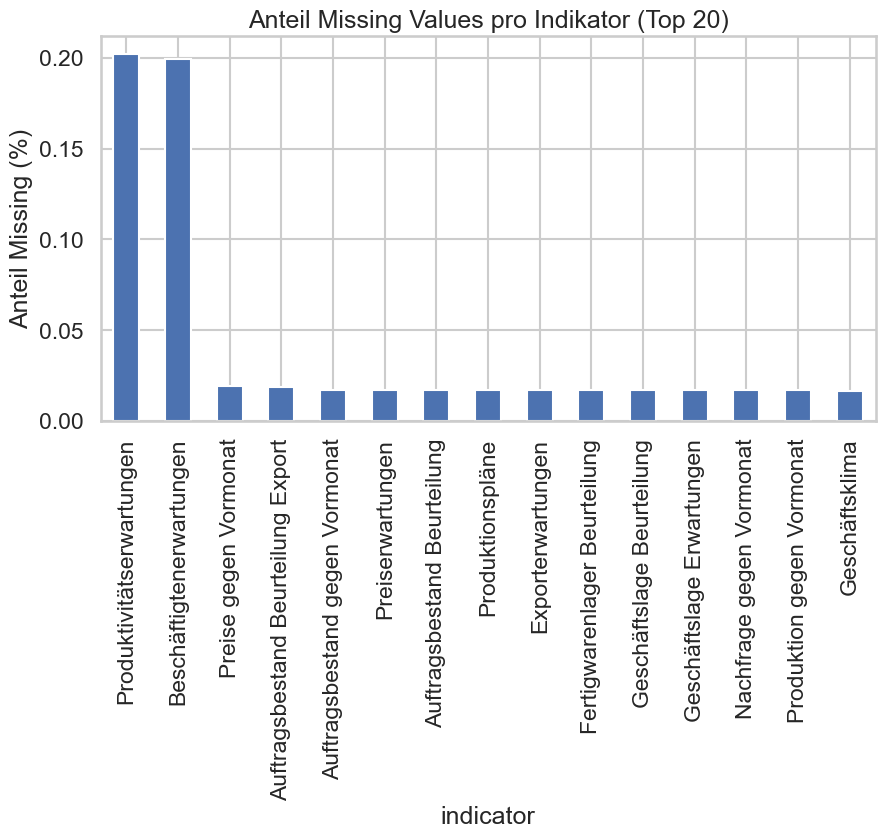

In [13]:
missing_by_indicator = (
    panel.groupby(["indicator"])["value"]
    .apply(lambda s: s.isna().mean())
    .sort_values(ascending=False)
)

plt.figure(figsize=(10,5))
missing_by_indicator.head(20).plot(kind="bar")  # nur Top 20
plt.ylabel("Anteil Missing (%)")
plt.title("Anteil Missing Values pro Indikator (Top 20)")
plt.show()


# Teil 2 der Exploration


### Loading


In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Panel laden (breites Format mit Indikatoren als Spalten)
from src.data.preprocess import load_features
X, y = load_features(diff_type="pct")

# falls du lieber das lange Panel anschauen willst:
# panel_long = pd.read_csv("../data/processed/ifo_panel.csv", parse_dates=["date"])



### Anteil NaN je Indikator / Länge Historie

In [19]:
# Anteil NaN pro Indikator
nan_share = X.isna().mean().sort_values(ascending=False)

# Historie je Indikator: erste/letzte verfügbare Periode
valid_periods = {}
for col in X.columns:
    notnull = X[col].dropna()
    if not notnull.empty:
        valid_periods[col] = {
            "first": notnull.index.min(),
            "last": notnull.index.max(),
            "span_months": (notnull.index.max() - notnull.index.min()).days // 30
        }
valid_periods_df = pd.DataFrame(valid_periods).T
valid_periods_df.head()
nan_share = X.isna().mean().sort_values(ascending=False)
print(nan_share)


indicator
Auftragsbestand Beurteilung           0.0
Auftragsbestand Beurteilung Export    0.0
Auftragsbestand gegen Vormonat        0.0
Beschäftigtenerwartungen              0.0
Exporterwartungen                     0.0
Fertigwarenlager Beurteilung          0.0
Geschäftsklima                        0.0
Geschäftslage Beurteilung             0.0
Geschäftslage Erwartungen             0.0
Nachfrage gegen Vormonat              0.0
Preise gegen Vormonat                 0.0
Preiserwartungen                      0.0
Produktion gegen Vormonat             0.0
Produktionspläne                      0.0
Produktivitätserwartungen             0.0
dtype: float64


Anteil Ausreißer (|z| > 4)

In [17]:
# z-Score pro Spalte
X_std = (X - X.mean()) / X.std(ddof=0)
outlier_share = (np.abs(X_std) > 4).mean().sort_values(ascending=False)
outlier_share.head(10)


indicator
Preiserwartungen                  0.009828
Auftragsbestand Beurteilung       0.007371
Auftragsbestand gegen Vormonat    0.007371
Beschäftigtenerwartungen          0.007371
Exporterwartungen                 0.007371
Geschäftsklima                    0.007371
Geschäftslage Beurteilung         0.007371
Geschäftslage Erwartungen         0.007371
Nachfrage gegen Vormonat          0.007371
Produktion gegen Vormonat         0.007371
dtype: float64